<a href="https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/numba_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
from numba import jit, njit

###Problem 1 - A First Numba Function

**1a)** To start our exploration of Numba's features, let's write a python function to add two numbers. We'll creatively name it `add`:

In [0]:
def add(x, y):
  return x + y # add code here

Now, let's test the function, first with two scalars:

In [55]:
add(1, 2)

3

**1b)** With numpy, we can use our function to add not just scalars, but vectors as well:

In [62]:
a = np.arange(0,10)
b = np.arange(1,11)

add(a, b) # add code here

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])

#### Profiling
A central feature of parallel programming, numba, and writing efficient code more generally is **profiling**, or understanding how long various pieces of your program take. Profiling tools are becoming ever more sophisticated, but for today we're going to stick with the tried-and-true method of timing things. An easy way to do this in python is using the `%timeit` magic function. Let's try it out on our addition function:

In [64]:
%timeit add(1,2)

87.3 ns ± 1.11 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


What's going on here? `%timeit` is running our function many times, and then reporting the average time it takes to run a million loops. This is generally a better approach than timing a single function execution, because it accounts for random events that may cause any given run to perform poorly.

**1c)** Compare the time it takes to run your function with array arguments, then your function vs python's add function (the standard ''+'' operator).

In [65]:
%timeit add(a, b) # add code here
%timeit a + b # add code here

505 ns ± 10.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
425 ns ± 2.92 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Okay, so our function has a little additional overhead, but it's not too bad. Now, let's see if numba can improve things for us. Let's use Numba's `jit` function to create a numba version of our addition function.

In [0]:
numba_add = jit(add)

More commonly, you will use `jit` as a decorator, by adding `@jit` to the line above your function definition, but the above version shows you that at heart, `@jit` is just a python function that takes other functions as its argument! By default, a Numba function saves the original python version of the function in the variable `py_func`. You can check that the original version gives you the same answer:

In [59]:
numba_add.py_func(a,b)

array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28])

Now, let's see how fast our pre-compiled addition function goes.

In [60]:
%timeit numba_add(a,b)

841 ns ± 14.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Our new compiled function is running even slower! What's going on here?

### Problem 2 - A Better Numba Function

**2a)** As we saw in the first example, Numba isn't going to speed up everything. Generally, Numba will help you most in circumstances where python's line-by-line interperability is slowing it down. We can use a slightly more complicated function to explore this. The following is a function to calculate the hypotenuse of two numbers, that is designed to compensate the computer's finite precision representation of numbers. Use the `@jit` decorate to generate a Numba version of this function.

In [0]:
@jit # add code here
def hypotenuse(x, y):
  # Implementation from https://en.wikipedia.org/wiki/Hypot
  x = abs(x);
  y = abs(y);
  t = min(x, y);
  x = max(x, y);
  t = t / x;
  return x * math.sqrt(1+t*t)

**2b)** Use the `%timeit` function to determine whether the Numba version of the hyptonenuse function is better than the original Python implementation.

In [70]:
%timeit hypotenuse(3,4)
%timeit hypotenuse.py_func(3,4)

169 ns ± 2.25 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
662 ns ± 8.21 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


**2c)** Numba functions can call other functions, provided they are also Numba functions. Below is a function that loops through two numpy arrays and puts their sum into an output array. Modify the following function to calculate the hypotenuse instead.

In [0]:
@njit # this is an alias for @jit(nopython=True)
def ex_func(x, y, out):
  for i in range(x.shape[0]):
    out[i] = hypot(x[i], y[i]) # change this line

In [72]:
in1 = np.arange(10, dtype=np.float64)
in2 = 2 * in1 + 1
out = np.empty_like(in1)

print('in1:', in1)
print('in2:', in2)

ex_func(in1, in2, out)

print('out:', out)

in1: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
in2: [ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19.]
out: [ 1.          3.16227766  5.38516481  7.61577311  9.8488578  12.08304597
 14.31782106 16.55294536 18.78829423 21.02379604]


###Problem 3 - The Julia Set
Now that we've got the basics of the Numba `jit` decorator down, let's have a little fun. A classic example problem in parallel programming is the calculation of a fractal (you'll see why tomorrow). Below is some code that calculates whether a numbers is a member of the Julia set, and then computes the set on a discrete domain. Modify the code to use Numba and test how much faster it is than the original python implementation.

In [0]:
@njit # add code here
def julia(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Julia
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(-0.8, 0.156)
    a = complex(x,y)
    for i in range(max_iters):
        a = a*a + c
        if (a.real*a.real + a.imag*a.imag) > 1000:
            return 0
    return 255

In [0]:
@njit # add code here
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = julia(real, imag, iters)
            image[y, x] = color

    return image

In [82]:
image = np.zeros((500, 750), dtype=np.uint8)
%timeit create_fractal(-2.0, 2.0, -1.0, 1.0, image, 200)

40.1 ms ± 222 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Want to see what you made? Run the following code to plot the image. Feel free to pick your favorite matplotlib color map :)

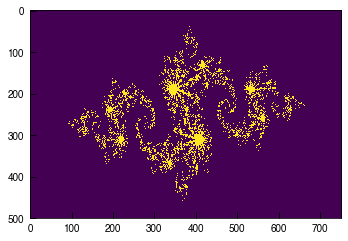

In [83]:
plt.imshow(image)
plt.viridis()
plt.show()